# DenseNet121

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import os

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transforms
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Specify data directory
data_dir = "/kaggle/input/agricultural-pests-image-dataset"

# Load datasets
image_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
dataloaders = DataLoader(image_dataset, batch_size=32, shuffle=True, num_workers=4)

# Check the classes
class_names = image_dataset.classes
print("Classes:", class_names)

Classes: ['ants', 'bees', 'beetle', 'catterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'weevil']


In [8]:
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features

# Modify classifier
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, len(class_names))
)

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ExponentialLR(optimizer, gamma=0.9)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 126MB/s] 


In [9]:
# Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        
        model.train()  # Set model to training mode
        
        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over data
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()  # Zero the parameter gradients
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(image_dataset)
        epoch_acc = running_corrects.double() / len(image_dataset)
        
        print(f"Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        print()
        
    return model

# Train the model
model = train_model(model, criterion, optimizer, scheduler)

Epoch 1/20
----------
Loss: 2.4058 Acc: 0.1467

Epoch 2/20
----------
Loss: 1.8870 Acc: 0.3628

Epoch 3/20
----------
Loss: 1.2942 Acc: 0.5588

Epoch 4/20
----------
Loss: 0.9585 Acc: 0.6727

Epoch 5/20
----------
Loss: 0.7641 Acc: 0.7419

Epoch 6/20
----------
Loss: 0.5754 Acc: 0.8078

Epoch 7/20
----------
Loss: 0.4727 Acc: 0.8497

Epoch 8/20
----------
Loss: 0.3724 Acc: 0.8857

Epoch 9/20
----------
Loss: 0.3243 Acc: 0.9013

Epoch 10/20
----------
Loss: 0.2802 Acc: 0.9212

Epoch 11/20
----------
Loss: 0.2292 Acc: 0.9398

Epoch 12/20
----------
Loss: 0.1634 Acc: 0.9543

Epoch 13/20
----------
Loss: 0.1432 Acc: 0.9620

Epoch 14/20
----------
Loss: 0.1693 Acc: 0.9549

Epoch 15/20
----------
Loss: 0.1268 Acc: 0.9681

Epoch 16/20
----------
Loss: 0.1422 Acc: 0.9632

Epoch 17/20
----------
Loss: 0.1593 Acc: 0.9614

Epoch 18/20
----------
Loss: 0.1151 Acc: 0.9718

Epoch 19/20
----------
Loss: 0.1238 Acc: 0.9698

Epoch 20/20
----------
Loss: 0.1052 Acc: 0.9783



Confusion Matrix:
[[499   0   0   0   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0   0   0]
 [  0   0 414   1   0   0   0   0   0   0   0   1]
 [  0   1   0 428   1   0   0   0   3   0   1   0]
 [  0   0   0   0 319   0   0   0   4   0   0   0]
 [  0   0   0   1   0 465   0   0   0   0   0   0]
 [  0   0   0   0   0   0 485   0   0   0   0   0]
 [  0   0   0   0   0   0   0 497   0   0   0   0]
 [  0   0   0   0   1   0   0   0 389   1   0   0]
 [  0   0   0   0   0   0   0   0   0 500   0   0]
 [  0   0   0   0   0   0   0   0   0   0 498   0]
 [  0   0   0   0   0   0   0   0   0   0   0 485]]
Classification Report:
              precision    recall  f1-score   support

        ants       1.00      1.00      1.00       499
        bees       1.00      1.00      1.00       500
      beetle       1.00      1.00      1.00       416
catterpillar       1.00      0.99      0.99       434
  earthworms       0.99      0.99      0.99       323
      earwig       1.

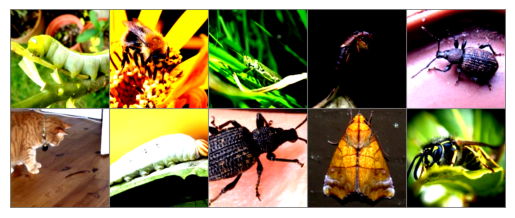

Ground Truth: catterpillar, bees, grasshopper, earwig, weevil, earthworms, catterpillar, weevil, moth, wasp
Predicted:    catterpillar, bees, grasshopper, earwig, weevil, earthworms, catterpillar, weevil, moth, wasp


In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Function to generate confusion matrix
def generate_confusion_matrix(model, dataloader):
    model.eval()   # Set model to evaluation mode
    all_preds = []
    all_labels = []

    # Iterate over data
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        # Collect predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Generate confusion matrix
    confusion_mat = confusion_matrix(all_labels, all_preds)
    return confusion_mat, all_labels, all_preds

# Generate confusion matrix
confusion_matrix, all_labels, all_preds = generate_confusion_matrix(model, dataloaders)
print("Confusion Matrix:")
print(confusion_matrix)

# Generate classification report
classification_rep = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:")
print(classification_rep)

# Predictions on 10 different images
model.eval()   # Set model to evaluation mode
image_paths = []  # Store image paths for reference
predicted_labels = []

# Select 10 random images from the dataset
sample_loader = DataLoader(image_dataset, batch_size=1, shuffle=True)
for i, (inputs, labels) in enumerate(sample_loader):
    if i >= 10:
        break
    
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # Forward pass
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    
    # Store image paths and predicted labels
    image_paths.append(sample_loader.dataset.samples[i][0])
    predicted_labels.append(class_names[preds.item()])

# Print predictions
print("\nPredictions on 10 different images:")
for path, label in zip(image_paths, predicted_labels):
    print(f"Image: {path}, Predicted Label: {label}")

# Plot the images with their predictions
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Load 10 random images
images = []
labels = []
for i, (image, label) in enumerate(sample_loader):
    if i >= 10:
        break
    images.append(image)
    labels.append(label)

# Make predictions
images = torch.cat(images, dim=0).to(device)
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Plot the images and their predictions
imshow(vutils.make_grid(images.cpu(), nrow=5))
print("Ground Truth:", ", ".join(f"{class_names[labels[j].item()]}" for j in range(10)))
print("Predicted:   ", ", ".join(f"{class_names[predicted[j].item()]}" for j in range(10)))


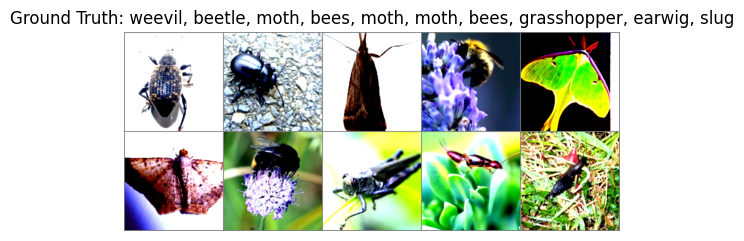

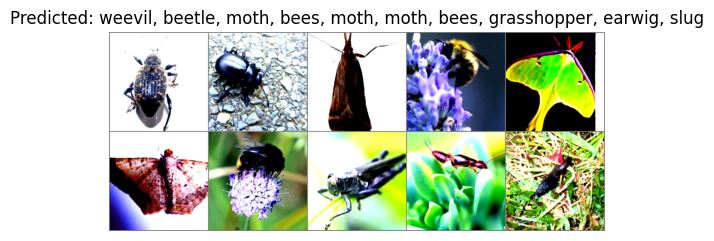

In [11]:
# Plot the images with their predictions
def imshow(img, title):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load 10 random images
images = []
labels = []
for i, (image, label) in enumerate(sample_loader):
    if i >= 10:
        break
    images.append(image)
    labels.append(label)

# Make predictions
images = torch.cat(images, dim=0).to(device)
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Plot the images and their predictions
imshow(vutils.make_grid(images.cpu(), nrow=5), "Ground Truth: " + ", ".join(f"{class_names[labels[j].item()]}" for j in range(10)))
imshow(vutils.make_grid(images.cpu(), nrow=5), "Predicted: " + ", ".join(f"{class_names[predicted[j].item()]}" for j in range(10)))


# Resnet 50

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import os

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transforms
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [14]:
data_dir = "/kaggle/input/agricultural-pests-image-dataset"

# Load datasets
image_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
dataloaders = DataLoader(image_dataset, batch_size=32, shuffle=True, num_workers=4)

# Check the classes
class_names = image_dataset.classes
print("Classes:", class_names)


Classes: ['ants', 'bees', 'beetle', 'catterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'weevil']


In [15]:
# Load pretrained ResNet-50
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features

# Modify classifier
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, len(class_names))
)

model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s] 


In [16]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ExponentialLR(optimizer, gamma=0.9)


In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        
        model.train()  # Set model to training mode
        
        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over data
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()  # Zero the parameter gradients
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(image_dataset)
        epoch_acc = running_corrects.double() / len(image_dataset)
        
        print(f"Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        print()
        
    return model

In [18]:
model = train_model(model, criterion, optimizer, scheduler)

Epoch 1/50
----------
Loss: 2.3197 Acc: 0.1624

Epoch 2/50
----------
Loss: 1.9802 Acc: 0.3145

Epoch 3/50
----------
Loss: 1.6161 Acc: 0.4518

Epoch 4/50
----------
Loss: 1.2740 Acc: 0.5635

Epoch 5/50
----------
Loss: 1.0151 Acc: 0.6589

Epoch 6/50
----------
Loss: 0.8376 Acc: 0.7226

Epoch 7/50
----------
Loss: 0.7367 Acc: 0.7668

Epoch 8/50
----------
Loss: 0.5863 Acc: 0.8163

Epoch 9/50
----------
Loss: 0.5384 Acc: 0.8342

Epoch 10/50
----------
Loss: 0.4506 Acc: 0.8755

Epoch 11/50
----------
Loss: 0.4004 Acc: 0.8959

Epoch 12/50
----------
Loss: 0.3470 Acc: 0.9103

Epoch 13/50
----------
Loss: 0.3179 Acc: 0.9237

Epoch 14/50
----------
Loss: 0.2310 Acc: 0.9439

Epoch 15/50
----------
Loss: 0.1982 Acc: 0.9543

Epoch 16/50
----------
Loss: 0.2035 Acc: 0.9474

Epoch 17/50
----------
Loss: 0.1795 Acc: 0.9583

Epoch 18/50
----------
Loss: 0.1676 Acc: 0.9594

Epoch 19/50
----------
Loss: 0.2904 Acc: 0.9383

Epoch 20/50
----------
Loss: 0.1600 Acc: 0.9691

Epoch 21/50
----------
Loss: 

In [19]:
def generate_classification_report(model, dataloader):
    model.eval()   # Set model to evaluation mode
    all_preds = []
    all_labels = []

    # Iterate over data
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        # Collect predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Generate classification report
    classification_rep = classification_report(all_labels, all_preds, target_names=class_names)
    return classification_rep

# Generate classification report
classification_report = generate_classification_report(model, dataloaders)
print("Classification Report:")
print(classification_report)

Classification Report:
              precision    recall  f1-score   support

        ants       1.00      1.00      1.00       499
        bees       1.00      1.00      1.00       500
      beetle       1.00      0.98      0.99       416
catterpillar       1.00      0.99      1.00       434
  earthworms       1.00      1.00      1.00       323
      earwig       0.98      1.00      0.99       466
 grasshopper       0.99      1.00      1.00       485
        moth       1.00      1.00      1.00       497
        slug       0.99      1.00      1.00       391
       snail       1.00      1.00      1.00       500
        wasp       1.00      1.00      1.00       498
      weevil       1.00      1.00      1.00       485

    accuracy                           1.00      5494
   macro avg       1.00      1.00      1.00      5494
weighted avg       1.00      1.00      1.00      5494



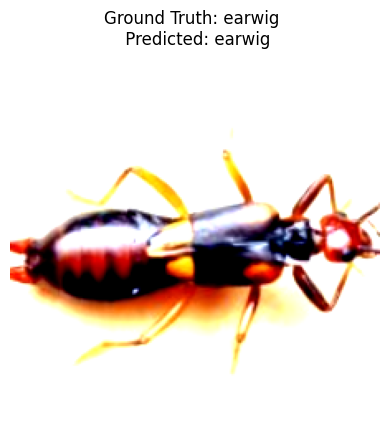

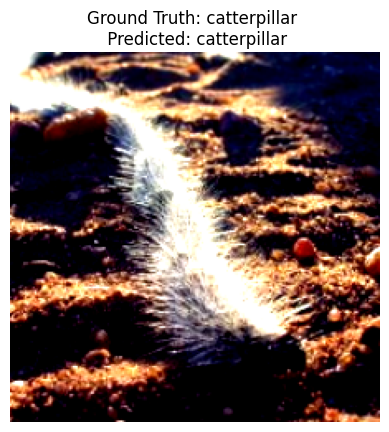

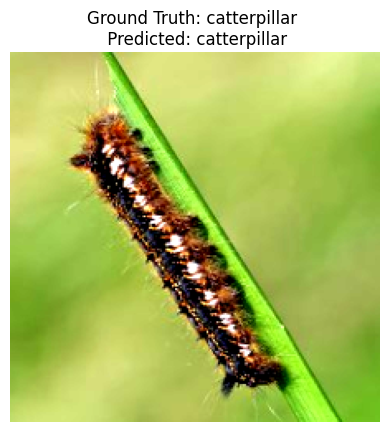

In [20]:
import random

# Function to display images with predicted labels
def imshow_with_prediction(img_tensor, label, predicted_label):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert tensor to numpy and transpose dimensions
    img = img / 2 + 0.5  # Unnormalize
    plt.imshow(img)
    plt.title(f'Ground Truth: {class_names[label]} \n Predicted: {class_names[predicted_label]}')
    plt.axis('off')
    plt.show()

# Load 3 random images from different folders
sample_images = []
sample_labels = []
for _ in range(3):
    random_class_index = random.randint(0, len(image_dataset.classes) - 1)  # Select a random class index
    random_image_index = random.randint(0, len(image_dataset.targets) - 1)  # Select a random image index
    while image_dataset.targets[random_image_index] != random_class_index:
        random_image_index = random.randint(0, len(image_dataset.targets) - 1)  # Select a random image index from the selected class
    sample_images.append(image_dataset[random_image_index][0])  # Append the image tensor
    sample_labels.append(image_dataset.targets[random_image_index])  # Append the true label

# Convert the list of tensors to a single tensor
sample_images = torch.stack(sample_images)

# Make predictions
with torch.no_grad():
    outputs = model(sample_images.to(device))
    _, predicted_labels = torch.max(outputs, 1)

# Display the images with their predicted labels
for i in range(3):
    imshow_with_prediction(sample_images[i], sample_labels[i], predicted_labels[i])


# CNN Model


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import random

In [22]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define data transforms
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Specify data directory
data_dir = "/kaggle/input/agricultural-pests-image-dataset"

# Load datasets
image_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
dataloaders = DataLoader(image_dataset, batch_size=32, shuffle=True, num_workers=4)

# Check the classes
class_names = image_dataset.classes
print("Classes:", class_names)

Classes: ['ants', 'bees', 'beetle', 'catterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'weevil']


In [23]:
# Define Simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SimpleCNN(len(class_names)).to(device)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        
        model.train()  # Set model to training mode
        
        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over data
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()  # Zero the parameter gradients
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(image_dataset)
        epoch_acc = running_corrects.double() / len(image_dataset)
        
        print(f"Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        print()
        
    return model

# Train the model
model = train_model(model, criterion, optimizer, scheduler)

Epoch 1/20
----------
Loss: 2.2369 Acc: 0.2348

Epoch 2/20
----------
Loss: 1.8454 Acc: 0.3930

Epoch 3/20
----------
Loss: 1.5637 Acc: 0.4924

Epoch 4/20
----------
Loss: 1.2736 Acc: 0.5817

Epoch 5/20
----------
Loss: 0.9858 Acc: 0.6928

Epoch 6/20
----------
Loss: 0.6970 Acc: 0.7883

Epoch 7/20
----------
Loss: 0.4243 Acc: 0.8821

Epoch 8/20
----------
Loss: 0.2447 Acc: 0.9432

Epoch 9/20
----------
Loss: 0.1170 Acc: 0.9809

Epoch 10/20
----------
Loss: 0.0643 Acc: 0.9924

Epoch 11/20
----------
Loss: 0.0353 Acc: 0.9965

Epoch 12/20
----------
Loss: 0.0160 Acc: 0.9996

Epoch 13/20
----------
Loss: 0.0085 Acc: 1.0000

Epoch 14/20
----------
Loss: 0.0047 Acc: 1.0000

Epoch 15/20
----------
Loss: 0.0033 Acc: 1.0000

Epoch 16/20
----------
Loss: 0.0025 Acc: 1.0000

Epoch 17/20
----------
Loss: 0.0020 Acc: 1.0000

Epoch 18/20
----------
Loss: 0.0017 Acc: 1.0000

Epoch 19/20
----------
Loss: 0.0014 Acc: 1.0000

Epoch 20/20
----------
Loss: 0.0012 Acc: 1.0000



In [26]:
def generate_confusion_matrix(model, dataloader):
    model.eval()   # Set model to evaluation mode
    all_preds = []
    all_labels = []

    # Iterate over data
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        # Collect predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Generate confusion matrix
    confusion_mat = confusion_matrix(all_labels, all_preds)
    return confusion_mat

# Generate confusion matrix
confusion_matrix = generate_confusion_matrix(model, dataloaders)
print("Confusion Matrix:")
print(confusion_matrix)

# Function to generate classification report
def generate_classification_report(model, dataloader):
    model.eval()   # Set model to evaluation mode
    all_preds = []
    all_labels = []

    # Iterate over data
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        # Collect predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Generate classification report
    class_report = classification_report(all_labels, all_preds, target_names=class_names)
    return class_report

# Generate classification report
classification_rep = generate_classification_report(model, dataloaders)
print("Classification Report:")
print(classification_rep)


Confusion Matrix:
[[499   0   0   0   0   0   0   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0   0   0]
 [  0   0 416   0   0   0   0   0   0   0   0   0]
 [  0   0   0 434   0   0   0   0   0   0   0   0]
 [  0   0   0   0 323   0   0   0   0   0   0   0]
 [  0   0   0   0   0 466   0   0   0   0   0   0]
 [  0   0   0   0   0   0 485   0   0   0   0   0]
 [  0   0   0   0   0   0   0 497   0   0   0   0]
 [  0   0   0   0   0   0   0   0 391   0   0   0]
 [  0   0   0   0   0   0   0   0   0 500   0   0]
 [  0   0   0   0   0   0   0   0   0   0 498   0]
 [  0   0   0   0   0   0   0   0   0   0   0 485]]
Classification Report:
              precision    recall  f1-score   support

        ants       1.00      1.00      1.00       499
        bees       1.00      1.00      1.00       500
      beetle       1.00      1.00      1.00       416
catterpillar       1.00      1.00      1.00       434
  earthworms       1.00      1.00      1.00       323
      earwig       1.

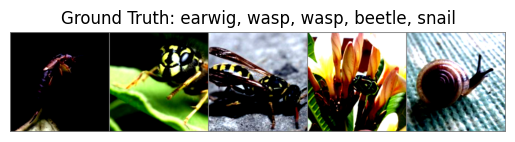

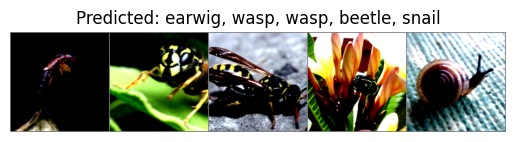

In [27]:
def imshow(img, title):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load 5 random images
sample_loader = DataLoader(image_dataset, batch_size=1, shuffle=True)
images = []
labels = []
for i, (image, label) in enumerate(sample_loader):
    if i >= 5:
        break
    images.append(image)
    labels.append(label)

# Make predictions
images = torch.cat(images, dim=0).to(device)
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Plot the images and their predictions
imshow(vutils.make_grid(images.cpu(), nrow=5), "Ground Truth: " + ", ".join(f"{class_names[labels[j].item()]}" for j in range(5)))
imshow(vutils.make_grid(images.cpu(), nrow=5), "Predicted: " + ", ".join(f"{class_names[predicted[j].item()]}" for j in range(5)))

# MobileNet

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import random

In [29]:
data_dir = "/kaggle/input/agricultural-pests-image-dataset"

# Load datasets
image_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
dataloaders = DataLoader(image_dataset, batch_size=32, shuffle=True, num_workers=4)

# Check the classes
class_names = image_dataset.classes
print("Classes:", class_names)

# Load pretrained MobileNetV2
model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features

# Modify classifier
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ExponentialLR(optimizer, gamma=0.9)

Classes: ['ants', 'bees', 'beetle', 'catterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'weevil']


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 86.8MB/s]


In [30]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        
        model.train()  # Set model to training mode
        
        running_loss = 0.0
        running_corrects = 0
        
        # Iterate over data
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()  # Zero the parameter gradients
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(image_dataset)
        epoch_acc = running_corrects.double() / len(image_dataset)
        
        print(f"Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        print()
        
    return model

# Train the model
model = train_model(model, criterion, optimizer, scheduler)


Epoch 1/10
----------
Loss: 0.7601 Acc: 0.7960

Epoch 2/10
----------
Loss: 0.2145 Acc: 0.9412

Epoch 3/10
----------
Loss: 0.0897 Acc: 0.9802

Epoch 4/10
----------
Loss: 0.0480 Acc: 0.9907

Epoch 5/10
----------
Loss: 0.0280 Acc: 0.9956

Epoch 6/10
----------
Loss: 0.0128 Acc: 0.9995

Epoch 7/10
----------
Loss: 0.0138 Acc: 0.9971

Epoch 8/10
----------
Loss: 0.0263 Acc: 0.9954

Epoch 9/10
----------
Loss: 0.0185 Acc: 0.9965

Epoch 10/10
----------
Loss: 0.0278 Acc: 0.9922



In [31]:
def generate_confusion_matrix(model, dataloader):
    model.eval()   # Set model to evaluation mode
    all_preds = []
    all_labels = []

    # Iterate over data
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        # Collect predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Generate confusion matrix
    confusion_mat = confusion_matrix(all_labels, all_preds)
    return confusion_mat

# Generate confusion matrix
conf_mat = generate_confusion_matrix(model, dataloaders)
print("Confusion Matrix:")
print(conf_mat)

# Function to generate classification report
def generate_classification_report(model, dataloader):
    model.eval()   # Set model to evaluation mode
    all_preds = []
    all_labels = []

    # Iterate over data
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        # Collect predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Generate classification report
    class_report = classification_report(all_labels, all_preds, target_names=class_names)
    return class_report

# Generate classification report
classification_rep = generate_classification_report(model, dataloaders)
print("Classification Report:")
print(classification_rep)

Confusion Matrix:
[[476   0  21   0   0   0   2   0   0   0   0   0]
 [  0 500   0   0   0   0   0   0   0   0   0   0]
 [  1   2 412   0   0   0   0   0   0   0   1   0]
 [  0   0   0 434   0   0   0   0   0   0   0   0]
 [  0   0   0   0 323   0   0   0   0   0   0   0]
 [  0   0   0   0   0 466   0   0   0   0   0   0]
 [  0   0   0   0   0   1 484   0   0   0   0   0]
 [  0   0   0   0   0   0   0 497   0   0   0   0]
 [  0   0   0   0   0   0   0   1 390   0   0   0]
 [  0   0   0   0   0   0   0   0   0 500   0   0]
 [  0   0   0   0   0   0   0   0   0   0 498   0]
 [  0   0   0   0   0   0   0   0   0   0   0 485]]
Classification Report:
              precision    recall  f1-score   support

        ants       1.00      0.95      0.98       499
        bees       1.00      1.00      1.00       500
      beetle       0.95      0.99      0.97       416
catterpillar       1.00      1.00      1.00       434
  earthworms       1.00      1.00      1.00       323
      earwig       1.

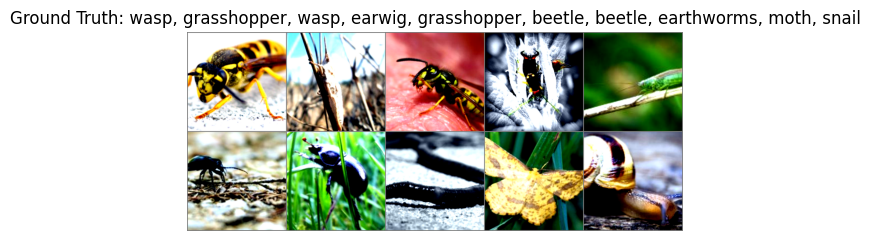

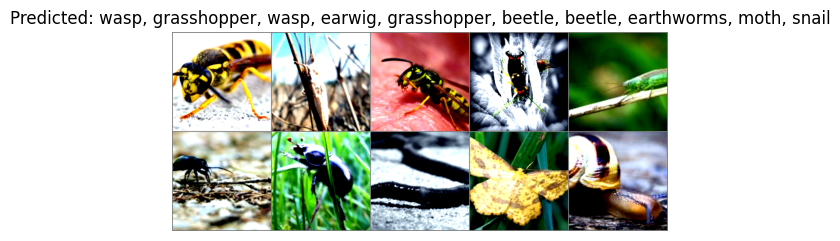

In [32]:
def imshow(img, title):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load 10 random images
sample_loader = DataLoader(image_dataset, batch_size=1, shuffle=True)
images = []
labels = []
for i, (image, label) in enumerate(sample_loader):
    if i >= 10:
        break
    images.append(image)
    labels.append(label)

# Make predictions
images = torch.cat(images, dim=0).to(device)
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Plot
imshow(vutils.make_grid(images.cpu(), nrow=5), "Ground Truth: " + ", ".join(f"{class_names[labels[j].item()]}" for j in range(10)))
imshow(vutils.make_grid(images.cpu(), nrow=5), "Predicted: " + ", ".join(f"{class_names[predicted[j].item()]}" for j in range(10)))